# Anotações e Entendimento Geral do Paper Pix2Pix GAN:
A arquitetura da rede Pix2Pix original proposta é um modelo de redes adversárias generativas (GANs) voltado para tarefas de tradução de imagem para imagem. Ela consiste em dois componentes principais: o Gerador (Generator) e o Discriminador (Discriminator).

### Gerador:
O gerador utiliza uma arquitetura de encoder-decoder com skip connections, semelhante à U-Net.
 - Encoder: c64-c128-c256-c512-c512-c512-c512-c512
 - Decoder: cd512-cd512-cd512-c512-c256-c128-c64

### Discriminador:
O discriminador utiliza uma arquitetura chamada PatchGAN. Em vez de classificar a imagem inteira como real ou falsa, ele divide a imagem em patches menores e faz a classificação em cada um desses patches.
- Arquitetura: c64-c128-c256-c512
- Camada Final: aplica uma convolução que transforma o mapa de ativação em uma dimensão (1D), seguida por uma função sigmoid para produzir a probabilidade de autenticidade.


## Desenvolvimento do Código:

### Importando bibliotecas

In [131]:
import os
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from keras.optimizers import Adam
from keras.initializers import RandomNormal

from keras.models import Model
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Conv2DTranspose
from keras.layers import BatchNormalization

from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array


## Carregando os Dados e Criando Datasets

Inicialmente a ideia é utilizar os datasets sugeridos pelo paper, escolhi o dataset "facades" por ser um dataset mais leve e menor. A ideia será a rede receber as imagens estilo "projeto arquitetônico" e a partir dele prever a imagem realista. Se der tempo, e ter GPU sobrando, tentarei fazer o processo reverso.

In [166]:
# DEFININDO ALGUMAS VARIÁVEIS "GLOBAIS" QUE SERÃO ÚTEIS POSTERIORMENTE:

BUFFER_SIZE = 400
BATCH_SIZE = 1 # seguindo análises do paper
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
INPUT_TEST = None
TARGET_TEST = None


In [50]:
# Como baixar o Dataset caso necessário (no caso desse notebook ele já está baixado na pasta facades):

"""
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]

# Caminho do diretório onde o dataset será salvo
current_dir = pathlib.Path().resolve()  # Caminho do diretório atual
destination_path = current_dir / 'datasets' / dataset_name

# Verifique se o dataset já foi baixado
if not destination_path.exists():
    _URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

    path_to_zip = tf.keras.utils.get_file(
        fname=f"{dataset_name}.tar.gz",
        origin=_URL,
        extract=True)

    path_to_zip = pathlib.Path(path_to_zip)
    extracted_path = path_to_zip.with_suffix('')  # tirando o .tar.gz
    PATH = extracted_path.parent / dataset_name

    destination_path.mkdir(parents=True, exist_ok=True)
    for item in PATH.iterdir():
        shutil.move(str(item), str(destination_path))

    # Remova a pasta original vazia
    PATH.rmdir()

    
    print(f"Dataset {dataset_name} salvo em {destination_path}")
else:
    print(f"Dataset {dataset_name} já existe em {destination_path}")

# Verifique o conteúdo do diretório do dataset movido
print(f"Conteúdo do dataset em {destination_path}:")
for item in destination_path.iterdir():
    print(item)
"""


'\n\ndataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]\n\n# Caminho do diretório onde o dataset será salvo\ncurrent_dir = pathlib.Path().resolve()  # Caminho do diretório atual\ndestination_path = current_dir / \'datasets\' / dataset_name\n\n# Verifique se o dataset já foi baixado\nif not destination_path.exists():\n    _URL = f\'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz\'\n\n    path_to_zip = tf.keras.utils.get_file(\n        fname=f"{dataset_name}.tar.gz",\n        origin=_URL,\n        extract=True)\n\n    path_to_zip = pathlib.Path(path_to_zip)\n    extracted_path = path_to_zip.with_suffix(\'\')  # tirando o .tar.gz\n    PATH = extracted_path.parent / dataset_name\n\n    destination_path.mkdir(parents=True, exist_ok=True)\n    for item in PATH.iterdir():\n        shutil.move(str(item), str(destination_path))\n\n    # Remova a pasta original vazia\n    PATH.rmdir()\n\n    \n    print(f"Dat

In [162]:
def load(path, size=(256, 256)):
    # Ler e decodificar um arquivo de imagem para um tensor uint8
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img)

    # Dividir cada tensor de imgm em dois tensores:
    # - um com a imgm real da fachada do prédio
    # - um com a imgm da etiqueta da arquitetura
    w = tf.shape(img)[1]
    w = w // 2
    input_img, real_img = img[:, w:, :], img[:, :w, :]

    # Converter ambas as imgns para tensores float32
    input_img = tf.cast(input_img, tf.float32)
    real_img = tf.cast(real_img, tf.float32)

    return input_img, real_img

### Imagem que será usada em todos os exemplos posteriores:
Para manter a consistência nos dados que estamos vizualizando, escolhi essa imagem para ser a imagem de exemplo 'datasets/facades/train/37.jpg' que serão INPUT_IMG e TARGET_IMG


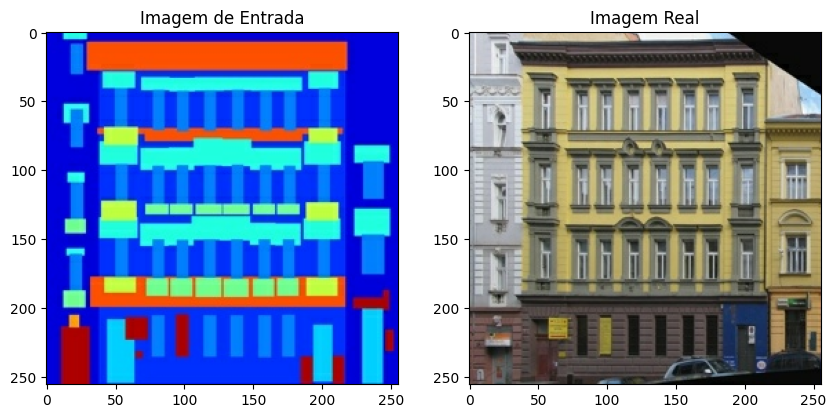

In [218]:
def plot_images(input_img, real_img):
    plt.figure(figsize=(10, 5))

    # Exibir a imgm de entrada
    plt.subplot(1, 2, 1)
    plt.title('Imagem de Entrada')
    plt.imshow(input_img / 255.0)  # Ajustar escala 

    # Exibir a imgm real
    plt.subplot(1, 2, 2)
    plt.title('Imagem Real')
    plt.imshow(real_img / 255.0)  # Ajustar escala

    plt.show()

path = 'facades/train/69.jpg'  
INPUT_IMAGE, TARGET_IMG = load(path)
plot_images(INPUT_IMAGE, TARGET_IMG)

Como descrito no artigo [pix2pix paper](https://arxiv.org/abs/1611.07004), você precisa aplicar jittering aleatório e espelhamento para preprocessar o conjunto de treinamento.

1. Redimensionem cada imagem 256 x 256 para uma altura e largura maiores (286 x 286).

2. Recortem aleatoriamente a imagem de volta para 256 x 256.

3. Virem aleatoriamente a imagem horizontalmente, ou seja espelhamento aleatório.
.
4. Normalizem as imagens para a faixa [-1, 1]..

Porém farei isso posteriormente, primeiro quero garantir que a rede funciona de maneira simples.

In [204]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [205]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [206]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [207]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

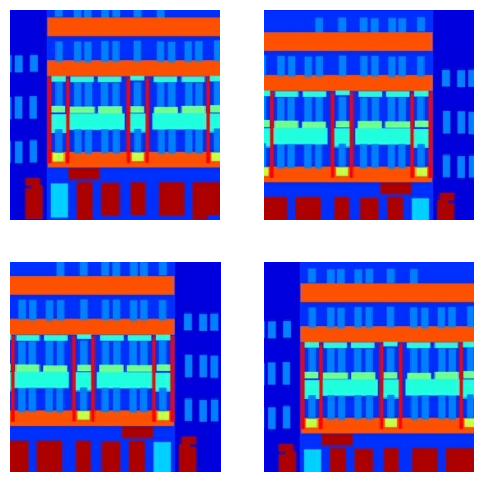

In [208]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [209]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [210]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [211]:
train_dataset = tf.data.Dataset.list_files('facades/train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
  test_dataset = tf.data.Dataset.list_files('facades/test/*.jpg')
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files('facades/val/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Definindo o Gerador

O gerador do seu pix2pix cGAN é uma U-Net modificada. Uma U-Net consiste em um codificador (downsampler) e um decodificador (upsampler). Você pode saber mais sobre ela no tutorial de segmentação de imagens e no site do projeto U-Net.

 - Cada bloco no codificador é: Convolução -> Normalização em Lote (Batch normalization) -> Leaky ReLU
 - Cada bloco no decodificador é: Convolução Transposta -> Normalização em Lote -> Dropout (aplicado nos primeiros 3 blocos) -> ReLU
 - Existem conexões de salto (skip connections) entre o codificador e o decodificador, como na U-Net.

In [164]:
def downsample(filters, size, apply_batchnorm=True):
  init = RandomNormal(stddev=0.02)

  res = tf.keras.Sequential()
  res.add(Conv2D(filters, (size, size), strides=(2,2), padding='same', kernel_initializer=init))

  if apply_batchnorm:
      res.add(BatchNormalization())

  res.add(LeakyReLU(negative_slope=0.2))

  return res

In [165]:
def upsample(filters, size, apply_dropout=False):
  init = RandomNormal(stddev=0.02)

  res = tf.keras.Sequential()
  res.add(Conv2DTranspose(filters, (size, size), strides=(2,2), padding='same', kernel_initializer=init))
  res.add(BatchNormalization())

  if apply_dropout:
      res.add(Dropout(0.5))

  return res

In [157]:
def Generator(img_shape=(256,256,3)):
  init = RandomNormal(stddev=0.02)

  in_img = Input(shape=img_shape)

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    downsample(512, 4), 
    downsample(512, 4), 
    downsample(512, 4), 
    downsample(512, 4), 
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  
    upsample(512, 4, apply_dropout=True), 
    upsample(512, 4, apply_dropout=True),  
    upsample(512, 4),  
    upsample(256, 4),  
    upsample(128, 4), 
    upsample(64, 4), 
  ]

  x = in_img

  # Downsampling
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Bottleneck
  x = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)

  # Upsampling
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = Concatenate()([x, skip])
    x =  Activation('relu')(x)

  x = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(x)
  out_img = Activation('tanh')(x)

  model = Model(in_img, out_img)
  return model

# Criação e visualização do modelo
generator = Generator()
generator.summary()

# CASO QUERIA PRINTAR A IMAGEM DO MODELO:
# tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


Model: "functional_195"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_156     │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_151      │ (None, 128, 128,  │      3,136 │ input_layer_156[… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_152      │ (None, 64, 64,    │    131,712 │ sequential_151[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_153      │ (None, 32, 32,    │    525,568 │ sequential_152[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_154      │ (None, 16, 16,    │  2,099,712 │ sequential_153[0… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_155      │ (None, 8, 8, 512) │  4,196,864 │ sequential_154[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_156      │ (None, 4, 4, 512) │  4,196,864 │ sequential_155[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_157      │ (None, 2, 2, 512) │  4,196,864 │ sequential_156[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_158      │ (None, 1, 1, 512) │  4,196,864 │ sequential_157[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_186 (Conv2D) │ (None, 1, 1, 512) │  4,194,816 │ sequential_158[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_159      │ (None, 2, 2, 512) │  4,196,864 │ conv2d_186[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_54      │ (None, 2, 2,      │          0 │ sequential_159[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_157[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_55       │ (None, 2, 2,      │          0 │ concatenate_54[0… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_160      │ (None, 4, 4, 512) │  8,391,168 │ activation_55[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_55      │ (None, 4, 4,      │          0 │ sequential_160[0… │
│ (Concatenate)       │ 1024)             │            │ sequential_156[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_56       │ (None, 4, 4,      │          0 │ concatenate_55[0… │
│ (Activation)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_161      │ (None, 8, 8, 512) │  8,391,168 │ activation_56[0]… │
│ (Sequential)        │                   │            │                 

 Total params: 58,626,179 (223.64 MB)

 Trainable params: 58,615,299 (223.60 MB)

 Non-trainable params: 10,880 (42.50 KB)

Shape da entrada: (1, 256, 256, 3)
Shape da saída: (1, 256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


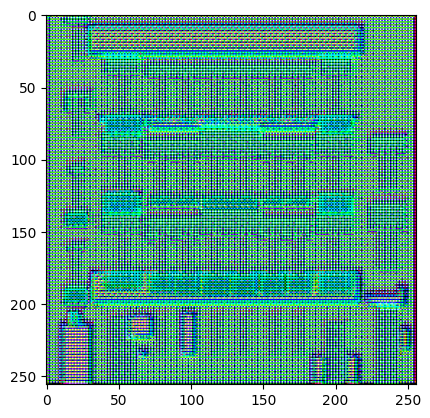

In [191]:
# Testando para uma entrada aleatória com o formato [1, 256, 256, 3]
test_input = np.random.random((1, 256, 256, 3)).astype(np.float32)
test_output = generator(test_input)

print(f"Shape da entrada: {test_input.shape}")
print(f"Shape da saída: {test_output.shape}")

# Testando com a imagem padrão de testes que definimos
gen_output = generator(INPUT_IMAGE[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

## Definindo o Descriminador

O discriminador no pix2pix cGAN é um classificador PatchGAN convolucional — ele tenta classificar se cada patch da imagem é real ou não, como descrito no artigo do pix2pix.

 - Cada bloco no discriminador é: Convolução ->Batch normalization -> Leaky ReLU.
 - A forma da saída após a última camada é (batch_size, 30, 30, 1).
 - Cada patch de imagem 30 x 30 da saída classifica uma porção 70 x 70 da imagem de entrada.

O discriminador recebe 2 entradas:
 - A imagem de entrada e a imagem alvo, que ele deve classificar como real.
 - A imagem de entrada e a imagem gerada (a saída do gerador), que ele deve classificar como falsa.
 

In [192]:

def block(filters, size, apply_batchnorm=True):
    init = RandomNormal(stddev=0.02)

    res = tf.keras.Sequential()
    res.add(Conv2D(filters, (size, size), strides=(2,2), padding='same', kernel_initializer=init))

    if apply_batchnorm:
        res.add(BatchNormalization())

    res.add(LeakyReLU(negative_slope=0.2))

    return res

def Discriminator(img_shape):
    init = RandomNormal(stddev=0.02) # Inicializador conforme o paper

    # Entrada de imagem de origem
    in_src_img = Input(shape=img_shape, name='input_image')
    # Entrada de imagem alvo
    in_target_img = Input(shape=img_shape, name='target_image')

    # Combinação das duas imagens
    merged_img = Concatenate()([in_src_img, in_target_img])

    layer = block(64, 4, False)(merged_img) # C64
    layer = block(128, 4)(layer) # C128
    layer = block(256, 4)(layer) # C256

    pad1 = tf.keras.layers.ZeroPadding2D()(layer)

    # Segunda última camada de saída
    layer = Conv2D(512, (4, 4), strides=1, kernel_initializer=init)(pad1)
    layer = BatchNormalization()(layer)
    layer = LeakyReLU(negative_slope=0.2)(layer)

    pad2 = tf.keras.layers.ZeroPadding2D()(layer)

    # Camada de saída do patch
    layer = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(pad2)

    # Define o modelo
    model = Model([in_src_img, in_target_img], layer)
    # Compila o modelo
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])

    return model

# Exemplo de uso
img_shape = (256, 256, 3)
discriminator = Discriminator(img_shape)
discriminator.summary()

# SE QUISER PLOTAR O MODELO:
# tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

Model: "functional_234"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_70      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_196      │ (None, 128, 128,  │      6,208 │ concatenate_70[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_197      │ (None, 64, 64,    │    131,712 │ sequential_196[0… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_198      │ (None, 32, 32,    │    525,568 │ sequential_197[0… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_35   │ (None, 34, 34,    │          0 │ sequential_198[0… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_238 (Conv2D) │ (None, 31, 31,    │  2,097,664 │ zero_padding2d_3… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_238[0][0]  │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_198     │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_36   │ (None, 33, 33,    │          0 │ leaky_re_lu_198[… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_239 (Conv2D) │ (None, 33, 33, 1) │      8,193 │ zero_padding2d_3… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,771,393 (10.57 MB)

 Trainable params: 2,769,601 (10.57 MB)

 Non-trainable params: 1,792 (7.00 KB)

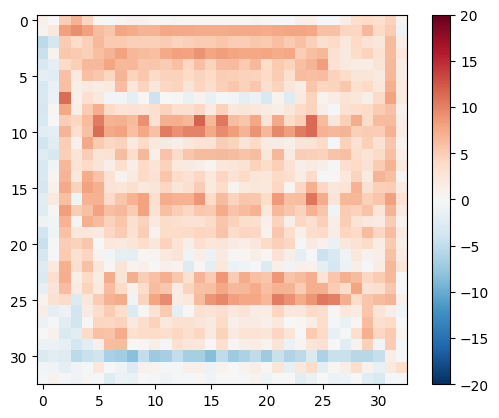

In [193]:
disc_out = discriminator([INPUT_IMAGE[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## Definindo as Losses

### Loss do Gerador

GANs aprendem uma função de perda que se adapta aos dados, enquanto cGANs aprendem uma função de perda estruturada que penaliza uma possível estrutura que difere da saída da rede e da imagem alvo.

A perda do gerador é uma perda de entropia cruzada sigmoide das imagens geradas e um array de uns.

O artigo do pix2pix também utiliza MAE (erro absoluto médio) entre a imagem gerada e a imagem alvo.

Isso permite que a imagem gerada se torne estruturalmente semelhante à imagem alvo.

A fórmula para calcular a perda total do gerador é gan_loss + LAMBDA * MAE, onde LAMBDA = 100 conforme o artigo.

In [120]:
# Definindo a Loss do Gerador
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def Generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # MAE
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

### Loss do Descriminador

A função discriminator_loss recebe 2 entradas: imagens reais e imagens geradas.

 - A real_loss é a perda Sigmoid Cross-entropy das imagens reais e um array de uns (imagens reais).
 - A generated_loss é a perda de Sigmoid Cross-entropy das imagens geradas e um array de zeros (imagens falsas).
 - A total_loss é a soma de real_loss e generated_loss.

In [121]:
# Definindo a Loss do Descriminador
def Discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [122]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [214]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

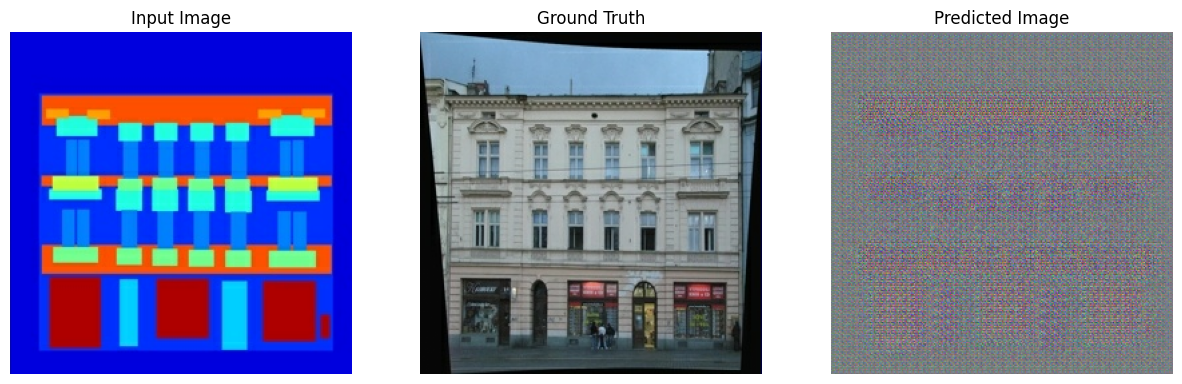

In [219]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## Treinamento

Para cada exemplo de entrada, uma saída. O discriminador recebe a `input_image` e a imagem gerada como a primeira entrada. A segunda entrada é a `input_image`e a `target_image`. Em seguida, calcula a loss do gerador e do discriminador. Depois, faz o backpropagation em relação às variáveis do gerador e do discriminador (entradas) e aplica esses gradientes ao otimizador.

In [220]:
# Definir diretório para checkpoints e logs
checkpoint_dir = './training_checkpoints'
log_dir = './logs'

# Criar diretórios se não existirem
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# Definir prefixo para checkpoints
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# Configurar checkpoints
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [221]:
# Função de treinamento
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss

# Função para salvar logs em um arquivo
def save_logs(log_file, step, gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss):
    with open(log_file, 'a') as f:
        f.write(f'Step: {step}, Gen Total Loss: {gen_total_loss.numpy()}, Gen GAN Loss: {gen_gan_loss.numpy()}, Gen L1 Loss: {gen_l1_loss.numpy()}, Disc Loss: {disc_loss.numpy()}\n')

In [226]:
from tqdm import tqdm


def fit(train_ds, test_ds, steps):
    example_input, example_target = next(iter(test_ds.take(1)))
    start = time.time()

    # Arquivo de log
    log_file = os.path.join(log_dir, 'training.log')

    for step, (input_image, target) in tqdm(enumerate(train_ds.repeat().take(steps)), total=steps, desc='Training Progress'):
        # Passo de treinamento
        gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss = train_step(input_image, target, step)

        # Salvando logs a cada 1000 passos
        if (step + 1) % 100 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f'Tempo decorrido para 1000 passos: {time.time() - start:.2f} segundos\n')
            start = time.time()

            # Gerar imagens para exibir progresso
            generate_images(generator, example_input, example_target)
            print(f"Passo: {step // 1000}k")

            # Salvar logs
            save_logs(log_file, step, gen_total_loss, gen_gan_loss, gen_l1_loss, disc_loss)

        # Imprimir ponto a cada 10 passos
        if (step + 1) % 10 == 0:
            print('.', end='', flush=True)

        # Salvar checkpoint a cada 5000 passos
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [227]:
fit(train_dataset, test_dataset, steps=40000)

Training Progress:   0%|          | 2/40000 [00:21<117:15:46, 10.55s/it]


KeyboardInterrupt: 